# Previsão de Vendas por SKU - Foco em Logística e Supply Chain

**Autor:** Victor Alexandre

**Data:** Maio de 2025

---

## 1. Introdução e Objetivos

Este projeto tem como objetivo principal desenvolver e avaliar modelos de previsão de vendas diárias em nível de SKU (Stock Keeping Unit - Unidade de Manutenção de Estoque). Utilizando dados históricos de vendas, exploraremos diferentes abordagens, desde modelos clássicos de séries temporais até técnicas avançadas de Machine Learning, para prever a demanda futura de itens específicos em diferentes lojas.

Os objetivos específicos incluem:

*   Realizar uma Análise Exploratória de Dados (EDA) detalhada para identificar tendências, sazonalidades e outros padrões relevantes.
*   Implementar engenharia de features para criar variáveis preditivas a partir de informações temporais (lags, janelas móveis, features de calendário).
*   Treinar, avaliar e comparar a performance de múltiplos modelos de previsão:
    *   Baseline Simples (Naive Forecast)
    *   ARIMA (AutoRegressive Integrated Moving Average)
    *   Prophet (Desenvolvido pelo Facebook)
    *   Random Forest Regressor
    *   XGBoost (Extreme Gradient Boosting)
*   Avaliar os modelos utilizando métricas apropriadas para previsão (RMSE e MAPE) e análise visual.
*   Interpretar os resultados, analisar a importância das features e discutir as implicações práticas dos modelos.

## 2. Contexto e Relevância para Supply Chain

A previsão de demanda precisa em nível de SKU é um pilar fundamental para a gestão eficiente da cadeia de suprimentos (Supply Chain) e operações logísticas. Erros de previsão podem levar a:

*   **Excesso de estoque:** Aumento dos custos de armazenagem, capital empatado e risco de obsolescência.
*   **Ruptura de estoque (Stockout):** Perda de vendas, insatisfação do cliente e possível perda de participação de mercado.

Modelos de previsão robustos permitem às empresas otimizar os níveis de estoque, melhorar o planejamento de compras e produção, aumentar a eficiência da distribuição e, consequentemente, melhorar o nível de serviço ao cliente e a rentabilidade geral. Este projeto demonstra como a Ciência de Dados pode ser aplicada para enfrentar este desafio crítico.

## 3. Dataset Utilizado

Para este estudo, utilizaremos o dataset **"Store Item Demand Forecasting Challenge"**, disponível publicamente na plataforma Kaggle.

*   **Fonte:** [https://www.kaggle.com/competitions/store-item-demand-forecasting-challenge](https://www.kaggle.com/competitions/store-item-demand-forecasting-challenge)
*   **Conteúdo:** O dataset contém 5 anos (de 01/01/2013 a 31/12/2017) de dados diários de vendas (`sales`) para 50 itens (`item`) distintos em 10 lojas (`store`) diferentes, totalizando 913.000 registros no conjunto de treino.
*   **Características:** É um dataset ideal para séries temporais múltiplas, permitindo focar na previsão por combinação loja-item (SKU).

## 4. Metodologia e Ferramentas

O projeto seguirá as etapas padrão de um fluxo de trabalho de Ciência de Dados, utilizando o ambiente Google Colab e a linguagem Python com as seguintes bibliotecas principais:

*   **Manipulação de Dados:** Pandas, NumPy
*   **Visualização:** Matplotlib, Seaborn
*   **Modelagem de Séries Temporais:** Statsmodels (ARIMA), Prophet
*   **Modelagem de Machine Learning:** Scikit-learn (Random Forest), XGBoost
*   **Avaliação:** Scikit-learn (metrics)

O foco será na clareza do processo, na interpretabilidade dos resultados e na relevância prática das conclusões.

---

*(Abaixo, seguem as células de código para importação, análise e modelagem...)*

In [1]:
# Cell 2: Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
# from sklearn.model_selection import train_test_split # Não usaremos para split temporal principal
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid') # Estilo dos gráficos
plt.rcParams['figure.figsize'] = (15, 6) # Tamanho padrão dos gráficos
pd.set_option('display.float_format', lambda x: '%.3f' % x) # Formatação de floats

In [2]:
# Cell 3: Carregar os Dados
try:
    train_df = pd.read_csv('train.csv', parse_dates=['date'])
    test_df = pd.read_csv('test.csv', parse_dates=['date'])

    print("--- Dados de Treino Carregados ---")
    print(f"Formato: {train_df.shape}")
    print("\nInformações:")
    train_df.info()
    print("\nPrimeiras 5 Linhas:")
    print(train_df.head())
    print("\nÚltimas 5 Linhas:")
    print(train_df.tail())

    print("\n\n--- Dados de Teste Carregados ---")
    print(f"Formato: {test_df.shape}")
    print("\nInformações:")
    test_df.info()
    print("\nPrimeiras 5 Linhas:")
    print(test_df.head())

except FileNotFoundError:
    print("Erro: Arquivo 'train.csv' ou 'test.csv' não encontrado.")
    print("Verifique se os arquivos estão no diretório correto do Colab.")

--- Dados de Treino Carregados ---
Formato: (913000, 4)

Informações:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB

Primeiras 5 Linhas:
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10

Últimas 5 Linhas:
             date  store  item  sales
912995 2017-12-27     10    50     63
912996 2017-12-28     10    50     59
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82


--- Dados de Teste Carre

In [3]:
# Cell 4: Verificar valores ausentes
print("Valores Ausentes no Treino:", train_df.isnull().sum().sum())
print("Valores Ausentes no Teste:", test_df.isnull().sum().sum())

Valores Ausentes no Treino: 0
Valores Ausentes no Teste: 0


In [4]:
# Cell 5: Estatísticas Descritivas da coluna 'sales'
print("\nEstatísticas Descritivas (Vendas):")
print(train_df['sales'].describe())


Estatísticas Descritivas (Vendas):
count   913000.000
mean        52.250
std         28.801
min          0.000
25%         30.000
50%         47.000
75%         70.000
max        231.000
Name: sales, dtype: float64


In [5]:
# Cell 6: Ordenar por data
train_df = train_df.sort_values('date').reset_index(drop=True)

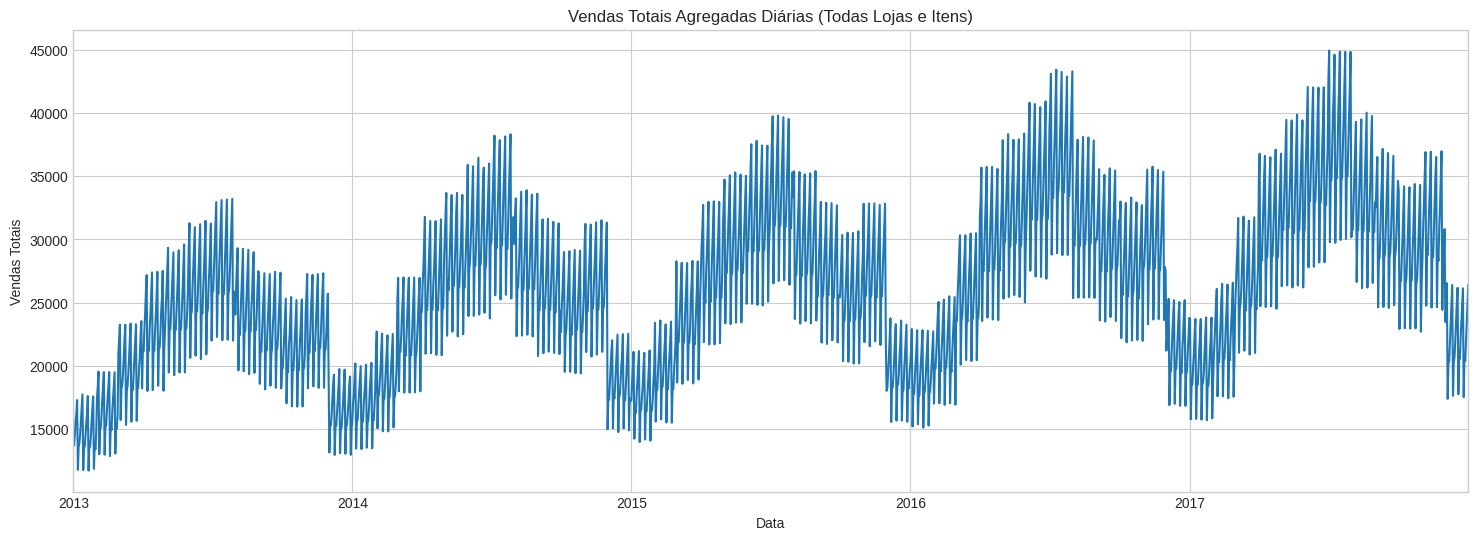

In [6]:
# Cell 7: Vendas totais ao longo do tempo (diário)
agg_sales_daily = train_df.groupby('date')['sales'].sum()

plt.figure(figsize=(18, 6))
agg_sales_daily.plot(title='Vendas Totais Agregadas Diárias (Todas Lojas e Itens)')
plt.ylabel('Vendas Totais')
plt.xlabel('Data')
plt.show()

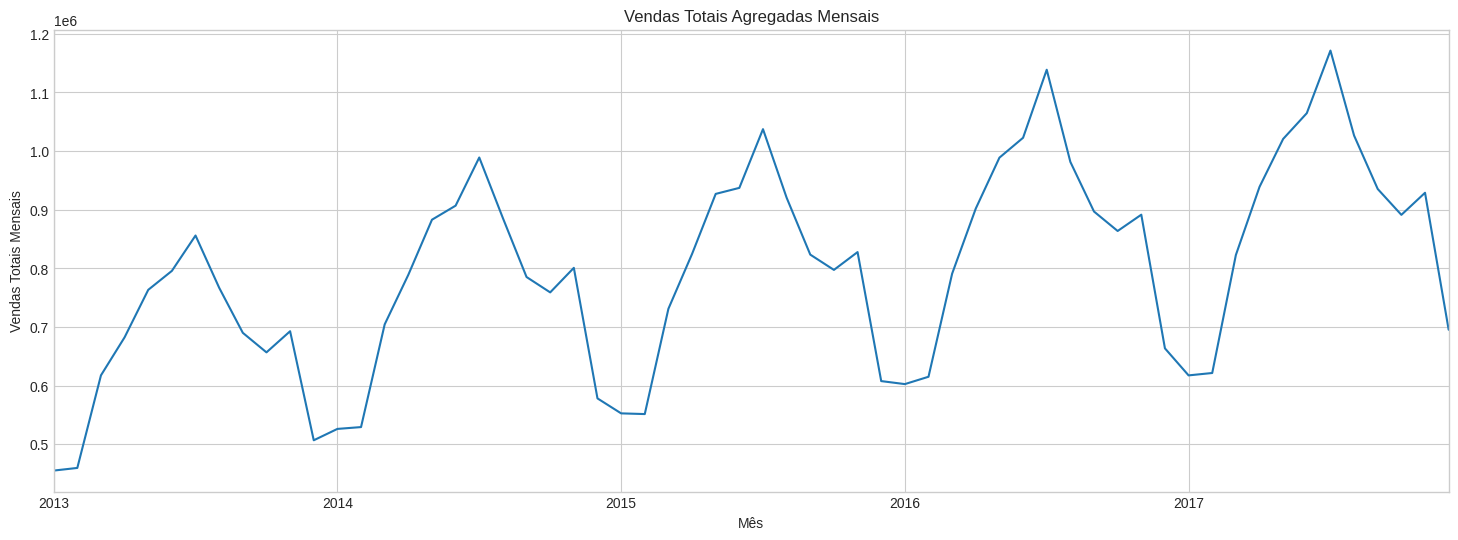

In [7]:
# Cell 8: Vendas totais mensais
# Certifique-se de que agg_sales_daily tem um índice de data
if not isinstance(agg_sales_daily.index, pd.DatetimeIndex):
    agg_sales_daily.index = pd.to_datetime(agg_sales_daily.index)
agg_sales_monthly = agg_sales_daily.resample('M').sum()

plt.figure(figsize=(18, 6))
agg_sales_monthly.plot(title='Vendas Totais Agregadas Mensais')
plt.ylabel('Vendas Totais Mensais')
plt.xlabel('Mês')
plt.show()

In [8]:
# Cell 9: Selecionar SKU (Loja 1, Item 1) e definir índice
store_id = 1
item_id = 1
df_sku = train_df[(train_df['store'] == store_id) & (train_df['item'] == item_id)].copy()
df_sku = df_sku.set_index('date')

print(f"--- Análise para Loja {store_id}, Item {item_id} ---")
print(f"Formato: {df_sku.shape}")
print(df_sku.head())

--- Análise para Loja 1, Item 1 ---
Formato: (1826, 3)
            store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10


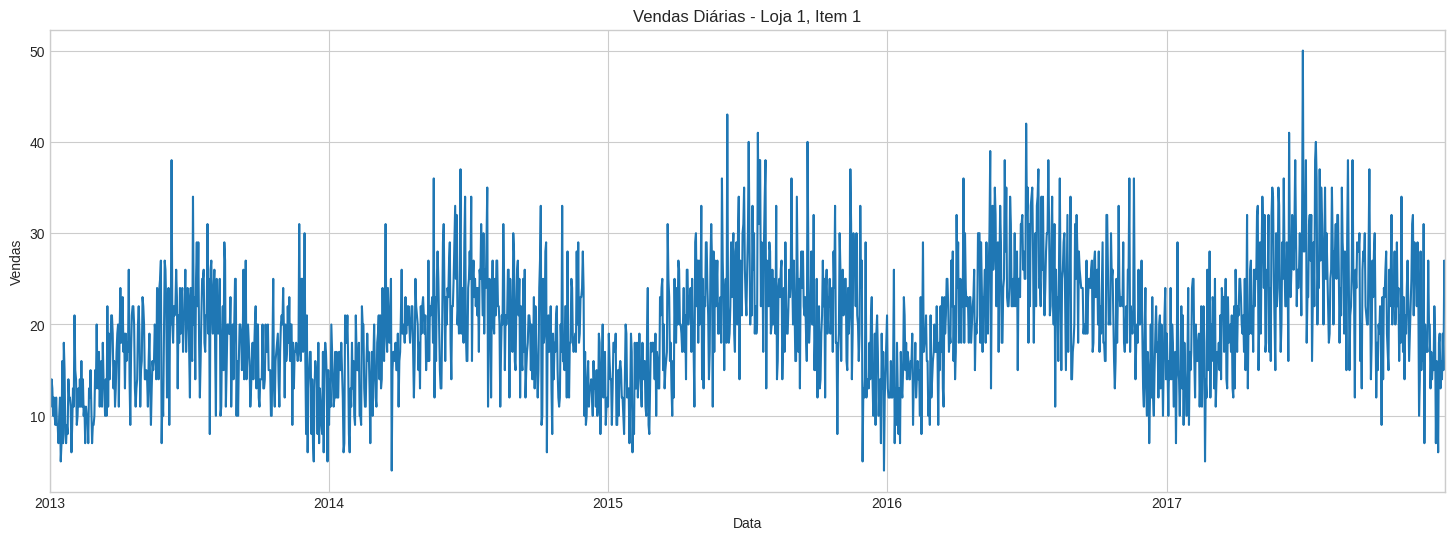

In [9]:
# Cell 10: Plotar vendas do SKU selecionado
plt.figure(figsize=(18, 6))
df_sku['sales'].plot(title=f'Vendas Diárias - Loja {store_id}, Item {item_id}')
plt.ylabel('Vendas')
plt.xlabel('Data')
plt.show()

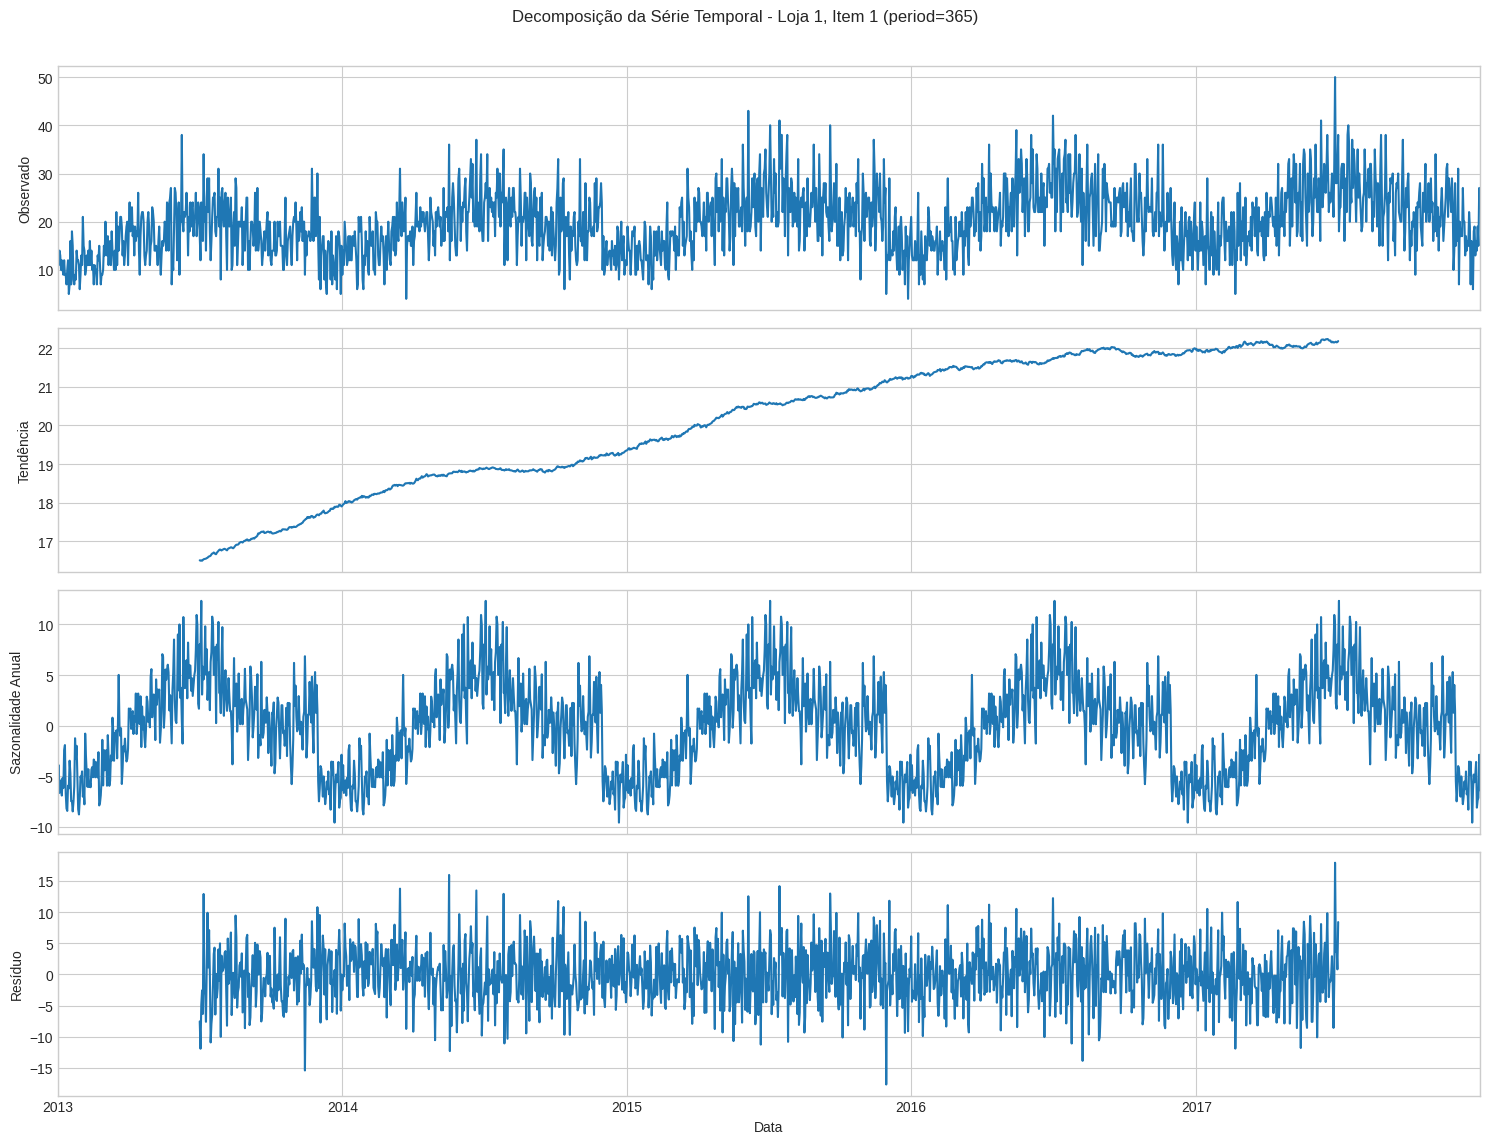

In [10]:
# Cell 11: Decomposição da Série Temporal
# Certifique-se de que o índice é DatetimeIndex
if not isinstance(df_sku.index, pd.DatetimeIndex):
     df_sku.index = pd.to_datetime(df_sku.index)

decomposition = seasonal_decompose(df_sku['sales'], model='additive', period=365)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
decomposition.observed.plot(ax=ax1, legend=False)
ax1.set_ylabel('Observado')
decomposition.trend.plot(ax=ax2, legend=False)
ax2.set_ylabel('Tendência')
decomposition.seasonal.plot(ax=ax3, legend=False)
ax3.set_ylabel('Sazonalidade Anual')
decomposition.resid.plot(ax=ax4, legend=False)
ax4.set_ylabel('Resíduo')
plt.suptitle(f'Decomposição da Série Temporal - Loja {store_id}, Item {item_id} (period=365)')
plt.xlabel('Data')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

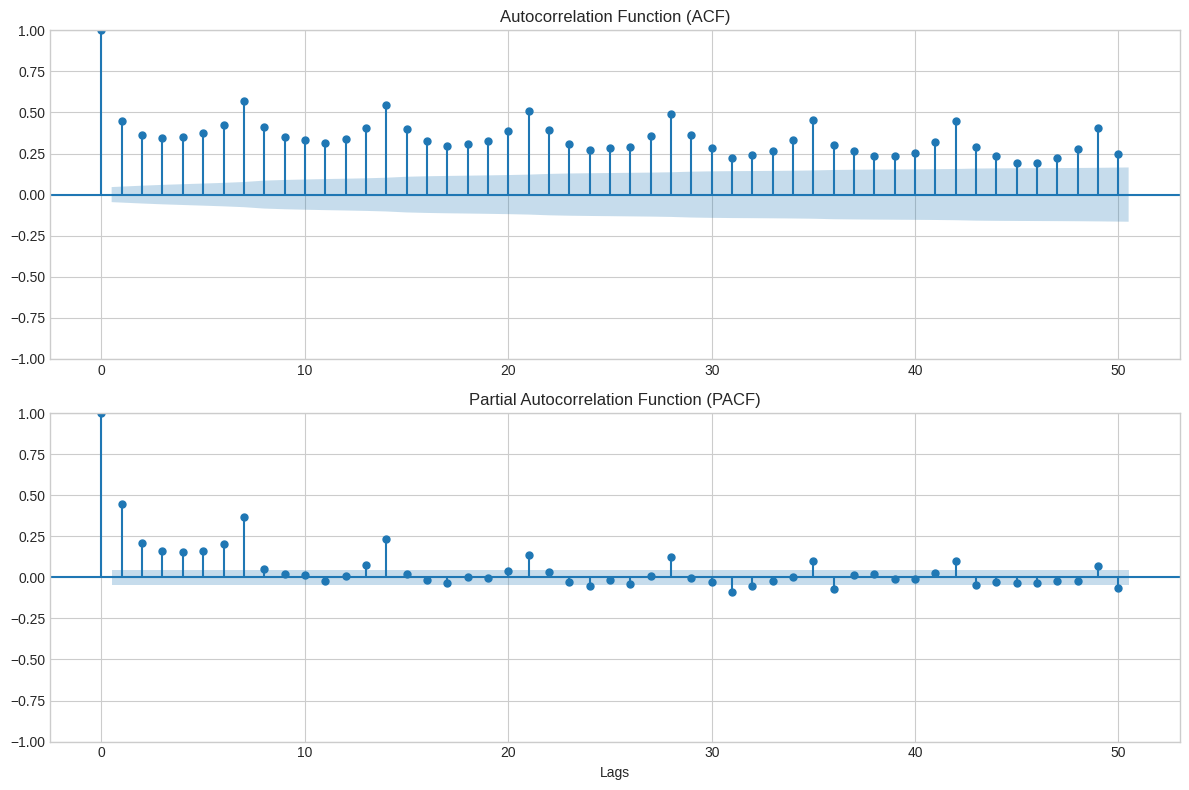

In [11]:
# Cell 12: Plotar ACF e PACF da série original do SKU
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_sku['sales'], lags=50, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')
plot_pacf(df_sku['sales'], lags=50, ax=ax2, method='ywm')
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.tight_layout()
plt.show()

In [12]:
# Cell 13: Resetar índice para Feature Engineering
df_sku_fe = df_sku.reset_index()

In [13]:
# Cell 14: Função para criar Features de Tempo
def create_time_features(df):
    df = df.copy()
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek # Segunda=0, Domingo=6
    df['dayofyear'] = df['date'].dt.dayofyear
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    return df

# Aplicar função
df_sku_fe = create_time_features(df_sku_fe)
print("DataFrame com Features de Tempo (head):")
print(df_sku_fe.head())

DataFrame com Features de Tempo (head):
        date  store  item  sales  year  month  day  dayofweek  dayofyear  \
0 2013-01-01      1     1     13  2013      1    1          1          1   
1 2013-01-02      1     1     11  2013      1    2          2          2   
2 2013-01-03      1     1     14  2013      1    3          3          3   
3 2013-01-04      1     1     13  2013      1    4          4          4   
4 2013-01-05      1     1     10  2013      1    5          5          5   

   weekofyear  quarter  is_weekend  
0           1        1           0  
1           1        1           0  
2           1        1           0  
3           1        1           0  
4           1        1           1  


In [14]:
# Cell 15: Função para criar Lag Features
def create_lag_features(df, target_col, lags):
    df = df.copy()
    df = df.sort_values('date')
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df

# Aplicar função
lags_to_create = [1, 7, 14, 28, 365]
df_sku_fe = create_lag_features(df_sku_fe, 'sales', lags_to_create)
print("\nDataFrame com Lag Features (tail):")
print(df_sku_fe.tail())


DataFrame com Lag Features (tail):
           date  store  item  sales  year  month  day  dayofweek  dayofyear  \
1821 2017-12-27      1     1     14  2017     12   27          2        361   
1822 2017-12-28      1     1     19  2017     12   28          3        362   
1823 2017-12-29      1     1     15  2017     12   29          4        363   
1824 2017-12-30      1     1     27  2017     12   30          5        364   
1825 2017-12-31      1     1     23  2017     12   31          6        365   

      weekofyear  quarter  is_weekend  sales_lag_1  sales_lag_7  sales_lag_14  \
1821          52        4           0       16.000       16.000        17.000   
1822          52        4           0       14.000       12.000        14.000   
1823          52        4           0       19.000        6.000        16.000   
1824          52        4           1       15.000       18.000        15.000   
1825          52        4           1       27.000       19.000        22.000   

  

In [15]:
# Cell 16: Função para criar Rolling Window Features
def create_rolling_features(df, target_col, windows, aggs=['mean', 'std']):
    df = df.copy()
    df = df.sort_values('date')
    shifted_sales = df[target_col].shift(1)
    for window in windows:
        rolling_op = shifted_sales.rolling(window=window, min_periods=1)
        if 'mean' in aggs:
            df[f'{target_col}_roll_mean_{window}'] = rolling_op.mean()
        if 'std' in aggs:
             df[f'{target_col}_roll_std_{window}'] = rolling_op.std()

    std_cols = [col for col in df.columns if 'roll_std' in col]
    df[std_cols] = df[std_cols].fillna(0)
    return df

# Aplicar função
windows_to_create = [7, 14, 28, 90, 365]
df_sku_fe = create_rolling_features(df_sku_fe, 'sales', windows_to_create, aggs=['mean', 'std'])
print("\nDataFrame com Rolling Features (tail):")
print(df_sku_fe.tail())


DataFrame com Rolling Features (tail):
           date  store  item  sales  year  month  day  dayofweek  dayofyear  \
1821 2017-12-27      1     1     14  2017     12   27          2        361   
1822 2017-12-28      1     1     19  2017     12   28          3        362   
1823 2017-12-29      1     1     15  2017     12   29          4        363   
1824 2017-12-30      1     1     27  2017     12   30          5        364   
1825 2017-12-31      1     1     23  2017     12   31          6        365   

      weekofyear  ...  sales_roll_mean_7  sales_roll_std_7  \
1821          52  ...             14.286             4.424   
1822          52  ...             14.000             4.359   
1823          52  ...             15.000             4.619   
1824          52  ...             16.286             2.430   
1825          52  ...             17.571             4.756   

      sales_roll_mean_14  sales_roll_std_14  sales_roll_mean_28  \
1821              15.000              4.438  

In [16]:
# Cell 17: Remover linhas com NaNs gerados pelos Lags/Rolling
print(f"\nShape antes de remover NaNs: {df_sku_fe.shape}")
df_sku_final = df_sku_fe.dropna(subset=[f'sales_lag_{max(lags_to_create)}']).copy()
print(f"Shape depois de remover NaNs: {df_sku_final.shape}")
print("\nDataFrame Final com Features (head):")
print(df_sku_final.head())


Shape antes de remover NaNs: (1826, 27)
Shape depois de remover NaNs: (1461, 27)

DataFrame Final com Features (head):
          date  store  item  sales  year  month  day  dayofweek  dayofyear  \
365 2014-01-01      1     1      9  2014      1    1          2          1   
366 2014-01-02      1     1     14  2014      1    2          3          2   
367 2014-01-03      1     1     11  2014      1    3          4          3   
368 2014-01-04      1     1     20  2014      1    4          5          4   
369 2014-01-05      1     1     17  2014      1    5          6          5   

     weekofyear  ...  sales_roll_mean_7  sales_roll_std_7  sales_roll_mean_14  \
365           1  ...             13.000             5.292              12.429   
366           1  ...             13.429             4.721              11.786   
367           1  ...             13.143             4.598              12.286   
368           1  ...             12.143             4.100              12.143   
369   

In [17]:
# Cell 18: Divisão Treino/Validação (Cronológica)
cutoff_date = '2017-01-01'
df_train = df_sku_final[df_sku_final['date'] < cutoff_date].copy()
df_val = df_sku_final[df_sku_final['date'] >= cutoff_date].copy()

print(f"Tamanho Treino: {df_train.shape}")
print(f"Tamanho Validação: {df_val.shape}")
print(f"Data início Treino: {df_train['date'].min()}, Data fim Treino: {df_train['date'].max()}")
print(f"Data início Validação: {df_val['date'].min()}, Data fim Validação: {df_val['date'].max()}")

Tamanho Treino: (1096, 27)
Tamanho Validação: (365, 27)
Data início Treino: 2014-01-01 00:00:00, Data fim Treino: 2016-12-31 00:00:00
Data início Validação: 2017-01-01 00:00:00, Data fim Validação: 2017-12-31 00:00:00


In [18]:
# Cell 19: Separar features (X) e target (y) para modelos ML
features = [col for col in df_sku_final.columns if col not in ['date', 'store', 'item', 'sales']]
target = 'sales'

X_train = df_train[features]
y_train = df_train[target]
X_val = df_val[features]
y_val = df_val[target]

print("\nShapes para Modelos ML:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")


Shapes para Modelos ML:
X_train: (1096, 23), y_train: (1096,)
X_val: (365, 23), y_val: (365,)


In [19]:
# Cell 20: Modelo Baseline (Naive Forecast)
y_pred_naive = X_val['sales_lag_1'].copy()
first_day_val_index = y_val.index[0]
if first_day_val_index in y_pred_naive.index: # Check if index exists before assigning
     last_day_train_sales = y_train.iloc[-1]
     y_pred_naive.loc[first_day_val_index] = last_day_train_sales
else:
     print(f"Warning: Index {first_day_val_index} not found in y_pred_naive. Skipping assignment for the first day.")


print("Previsões Baseline (Naive - head):")
print(y_pred_naive.head())
print("\nPrevisões Baseline (Naive - tail):")
print(y_pred_naive.tail())

# Handle potential remaining NaNs if lag_1 feature itself had NaNs at the start of X_val
y_pred_naive = y_pred_naive.fillna(method='ffill').fillna(method='bfill') # Simple forward/backward fill for any remaining NaNs

Previsões Baseline (Naive - head):
1461   14.000
1462   19.000
1463   15.000
1464   10.000
1465   16.000
Name: sales_lag_1, dtype: float64

Previsões Baseline (Naive - tail):
1821   16.000
1822   14.000
1823   19.000
1824   15.000
1825   27.000
Name: sales_lag_1, dtype: float64


In [20]:
# Cell 21: Teste de Estacionariedade (ADF) para ARIMA
train_series_arima = df_train.set_index('date')['sales']

adf_result = adfuller(train_series_arima)
print(f'--- Teste ADF na Série Original (Treino) ---')
print(f'ADF Statistic: {adf_result[0]:.3f}')
print(f'p-value: {adf_result[1]:.3f}')
if adf_result[1] > 0.05:
    print("Resultado: A série provavelmente NÃO é estacionária (p-value > 0.05). Necessita diferenciação.")
    d_suggestion = 1
else:
    print("Resultado: A série provavelmente é estacionária (p-value <= 0.05). d=0 pode ser considerado.")
    d_suggestion = 0

# Se precisar diferenciar:
if d_suggestion == 1:
    sales_diff = train_series_arima.diff().dropna()
    adf_result_diff = adfuller(sales_diff)
    print(f'\n--- Teste ADF na Série Diferenciada (d=1) ---')
    print(f'ADF Statistic: {adf_result_diff[0]:.3f}')
    print(f'p-value: {adf_result_diff[1]:.3f}')
    if adf_result_diff[1] <= 0.05:
        print("Resultado: A série diferenciada (d=1) é estacionária.")
    else:
        print("Resultado: A série diferenciada (d=1) AINDA não é estacionária. Considerar d=2?")

--- Teste ADF na Série Original (Treino) ---
ADF Statistic: -2.512
p-value: 0.113
Resultado: A série provavelmente NÃO é estacionária (p-value > 0.05). Necessita diferenciação.

--- Teste ADF na Série Diferenciada (d=1) ---
ADF Statistic: -11.792
p-value: 0.000
Resultado: A série diferenciada (d=1) é estacionária.


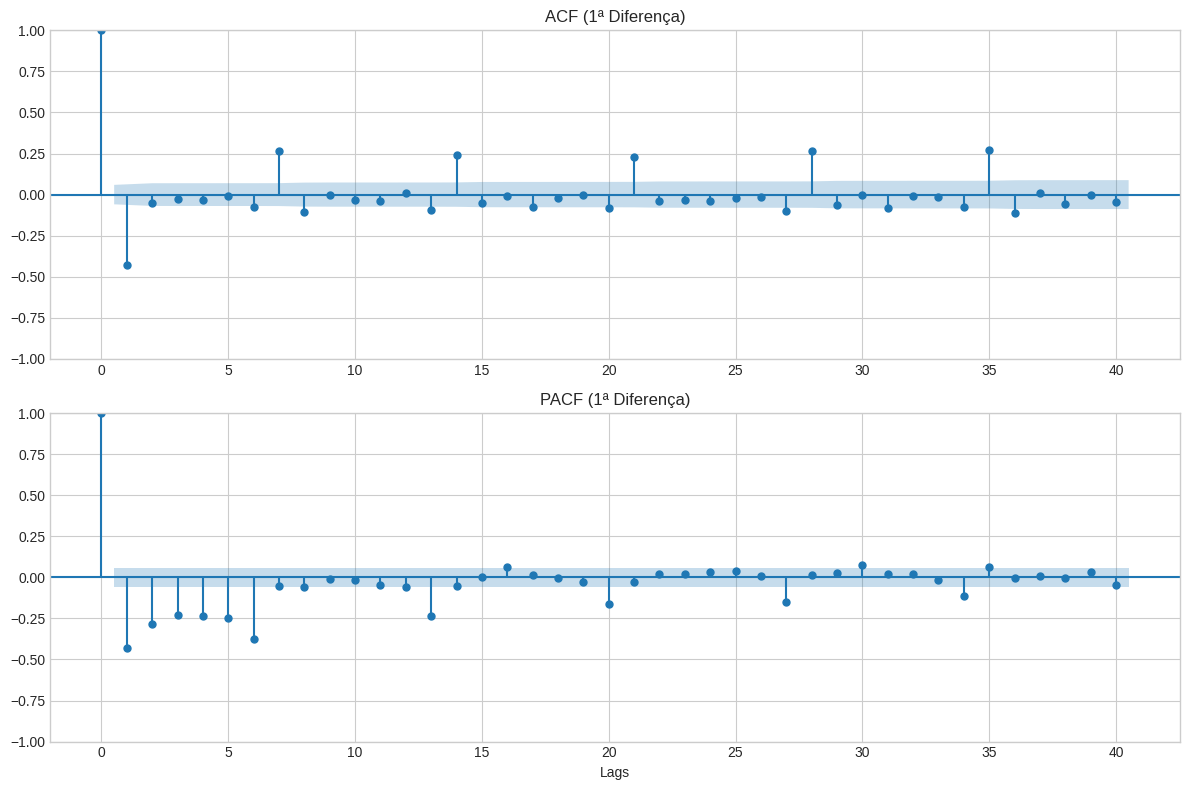

In [21]:
# Cell 22: Plotar ACF/PACF para ordens ARIMA
series_for_acf_pacf = train_series_arima if d_suggestion == 0 else train_series_arima.diff().dropna()
title_suffix = "(Original)" if d_suggestion == 0 else "(1ª Diferença)"

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(series_for_acf_pacf, lags=40, ax=ax1)
ax1.set_title(f'ACF {title_suffix}')
plot_pacf(series_for_acf_pacf, lags=40, ax=ax2, method='ywm')
ax2.set_title(f'PACF {title_suffix}')
plt.xlabel('Lags')
plt.tight_layout()
plt.show()

In [22]:
# Cell 23: Treinar Modelo ARIMA (Ajuste p, d, q conforme análise)
p, d, q = 7, d_suggestion, 1 # EXEMPLO - AJUSTE NECESSÁRIO
print(f"Tentando ARIMA com ordem: ({p}, {d}, {q})")

val_series_arima = df_val.set_index('date')['sales']

try:
    model_arima = ARIMA(train_series_arima, order=(p, d, q))
    arima_fit = model_arima.fit()
    print("\n--- Sumário do Modelo ARIMA ---")
    print(arima_fit.summary())

    start_index = val_series_arima.index[0]
    end_index = val_series_arima.index[-1]
    arima_preds = arima_fit.predict(start=start_index, end=end_index)

    print("\nPrevisões ARIMA (head):")
    print(arima_preds.head())

except Exception as e:
    print(f"\nErro ao treinar/prever com ARIMA({p},{d},{q}): {e}")
    arima_preds = pd.Series(np.nan, index=val_series_arima.index) # Preencher com NaN em caso de erro

Tentando ARIMA com ordem: (7, 1, 1)

--- Sumário do Modelo ARIMA ---
                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1096
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -3354.674
Date:                Mon, 05 May 2025   AIC                           6727.347
Time:                        04:06:17   BIC                           6772.334
Sample:                    01-01-2014   HQIC                          6744.370
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0391      0.049      0.794      0.427      -0.057       0.136
ar.L2         -0.0610      0.044     -1.386      0.166      -0

In [23]:
# Cell 24: Preparar dados para Prophet
prophet_train_df = df_train[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})
print("Dados formatados para Prophet (head):")
print(prophet_train_df.head())

Dados formatados para Prophet (head):
            ds   y
365 2014-01-01   9
366 2014-01-02  14
367 2014-01-03  11
368 2014-01-04  20
369 2014-01-05  17


In [24]:
# Cell 25: Instanciar e treinar Prophet
model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    growth='linear'
)
# model_prophet.add_country_holidays(country_name='US') # Exemplo

model_prophet.fit(prophet_train_df)
print("\nModelo Prophet treinado.")

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6op5__33/vrtqih43.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6op5__33/zjm_k8dm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5390', 'data', 'file=/tmp/tmp6op5__33/vrtqih43.json', 'init=/tmp/tmp6op5__33/zjm_k8dm.json', 'output', 'file=/tmp/tmp6op5__33/prophet_modelmljlex35/prophet_model-20250505040621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:06:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:06:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Modelo Prophet treinado.


In [25]:
# Cell 26: Criar dataframe futuro e prever com Prophet
future_dates = model_prophet.make_future_dataframe(periods=len(df_val), freq='D')
prophet_forecast = model_prophet.predict(future_dates)
print("\nDataFrame de Previsão Prophet (tail - com componentes):")
print(prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'yearly', 'weekly']].tail())


DataFrame de Previsão Prophet (tail - com componentes):
             ds   yhat  yhat_lower  yhat_upper  trend  yearly  weekly
1456 2017-12-27 16.964      11.534      22.951 24.001  -5.824  -1.213
1457 2017-12-28 17.563      11.768      23.470 24.005  -5.722  -0.720
1458 2017-12-29 19.630      14.300      25.043 24.009  -5.636   1.257
1459 2017-12-30 21.348      15.474      26.724 24.013  -5.567   2.902
1460 2017-12-31 22.483      16.681      27.890 24.017  -5.516   3.982


In [30]:
# Cell 27: Extrair e alinhar previsões Prophet para validação (CORRIGIDO - Garante DatetimeIndex)
# Pega as colunas 'ds' e 'yhat' do forecast onde a data é maior ou igual à data de corte
prophet_preds_df = prophet_forecast[prophet_forecast['ds'] >= cutoff_date][['ds', 'yhat']]
# Define a coluna 'ds' (que são as datas) como o índice do dataframe de previsões
prophet_preds_df = prophet_preds_df.set_index('ds')

# --- Correção chave: Reindexa a previsão usando o DatetimeIndex do dataframe de validação ---
# Cria um índice de data a partir da coluna 'date' do df_val
validation_datetime_index = df_val.set_index('date').index
# Alinha a série de previsões 'yhat' para ter exatamente o mesmo índice de datas que o conjunto de validação
prophet_preds = prophet_preds_df['yhat'].reindex(validation_datetime_index)
# Dá um nome à série (boa prática)
prophet_preds.name = 'prophet_pred'

print("\nPrevisões Prophet Finais (para validação - head):")
print(prophet_preds.head())
print("\nTipo do índice de prophet_preds:", type(prophet_preds.index)) # Verificar se é DatetimeIndex


Previsões Prophet Finais (para validação - head):
date
2017-01-01   21.066
2017-01-02   12.544
2017-01-03   15.441
2017-01-04   15.864
2017-01-05   16.325
Name: prophet_pred, dtype: float64

Tipo do índice de prophet_preds: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


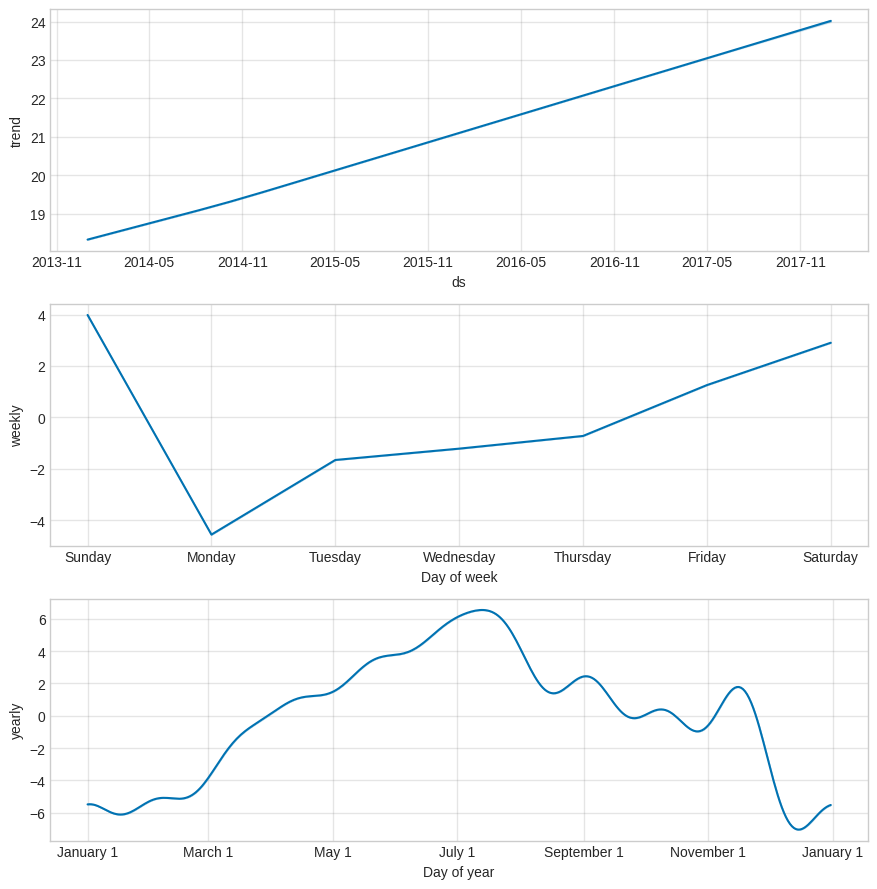

In [31]:
# Cell 28: Plotar componentes Prophet (opcional)
try:
  fig_prophet_comp = model_prophet.plot_components(prophet_forecast)
  plt.show()
except Exception as e:
  print(f"Não foi possível plotar componentes do Prophet: {e}")

In [32]:
# Cell 29: Modelo Random Forest (CORRIGIDO - Garante DatetimeIndex na previsão)
model_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1,
    max_features=0.8
)

print("Treinando Random Forest...")
model_rf.fit(X_train, y_train)
print("Treinamento concluído.")

# Prever no conjunto de validação
rf_preds_array = model_rf.predict(X_val) # Obtém as previsões como um array numpy

# --- Correção chave: Cria a série Pandas usando o DatetimeIndex correto ---
# Cria um índice de data a partir da coluna 'date' do df_val
validation_datetime_index = df_val.set_index('date').index
# Cria a Série Pandas usando o array de previsões e o índice de datas correto
rf_preds = pd.Series(rf_preds_array, index=validation_datetime_index, name='rf_pred')

print("\nPrevisões Random Forest (head):")
print(rf_preds.head())
print("\nTipo do índice de rf_preds:", type(rf_preds.index)) # Verificar se é DatetimeIndex

Treinando Random Forest...
Treinamento concluído.

Previsões Random Forest (head):
date
2017-01-01   19.693
2017-01-02   14.839
2017-01-03   14.432
2017-01-04   15.847
2017-01-05   16.189
Name: rf_pred, dtype: float64

Tipo do índice de rf_preds: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [33]:
# Cell 30: Modelo XGBoost (CORRIGIDO - Garante DatetimeIndex na previsão e corrige .fit)
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,            # Número máximo de rounds/árvores
    learning_rate=0.05,           # Taxa de aprendizado
    max_depth=7,                  # Profundidade máxima
    subsample=0.8,                # Fração de amostras por árvore
    colsample_bytree=0.8,         # Fração de features por árvore
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=20,     # Definir early stopping AQUI na inicialização
    eval_metric='rmse'            # Definir a métrica de avaliação AQUI na inicialização
)

print("Treinando XGBoost com Early Stopping...")
# O conjunto de validação é necessário para o early stopping funcionar
eval_set = [(X_val, y_val)] # Usar apenas o conjunto de validação para monitorar o early stopping

# Remover early_stopping_rounds e eval_metric do .fit()
model_xgb.fit(X_train, y_train,
              eval_set=eval_set, # Passar o eval_set para o fit (essencial para early stopping)
              verbose=False)      # Controla se imprime o progresso
print("Treinamento concluído.")

# Verificar se o early stopping ocorreu e qual a melhor iteração
try:
    best_iteration = model_xgb.best_iteration
    print(f"Early stopping at iteration: {best_iteration}")
except AttributeError:
     best_iteration = model_xgb.n_estimators # Assume que rodou todas as iterações
     print(f"Early stopping not triggered or attribute not found. Used n_estimators: {best_iteration}")


# Prever no conjunto de validação
xgb_preds_array = model_xgb.predict(X_val) # Obtém as previsões como um array numpy

# --- Correção chave: Cria a série Pandas usando o DatetimeIndex correto ---
# Cria um índice de data a partir da coluna 'date' do df_val
validation_datetime_index = df_val.set_index('date').index
# Cria a Série Pandas usando o array de previsões e o índice de datas correto
xgb_preds = pd.Series(xgb_preds_array, index=validation_datetime_index, name='xgb_pred')

print("\nPrevisões XGBoost (head):")
print(xgb_preds.head())
print("\nTipo do índice de xgb_preds:", type(xgb_preds.index)) # Verificar se é DatetimeIndex

Treinando XGBoost com Early Stopping...
Treinamento concluído.
Early stopping at iteration: 67

Previsões XGBoost (head):
date
2017-01-01   19.380
2017-01-02   15.108
2017-01-03   15.194
2017-01-04   15.174
2017-01-05   15.670
Name: xgb_pred, dtype: float32

Tipo do índice de xgb_preds: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [34]:
# Cell 31: Função e cálculo de Métricas (CORRIGIDO)

# Dicionário para armazenar resultados
results = {}

# Função para calcular e imprimir métricas
# (A função em si está OK, o problema é como os dados são passados para ela)
def calculate_metrics(y_true, y_pred, model_name):
    # Robustez: Verificar se ambos os índices são DatetimeIndex
    # Idealmente, isso já foi garantido antes de chamar a função
    if not isinstance(y_true.index, pd.DatetimeIndex):
         print(f"ALERTA CRÍTICO: y_true para {model_name} NÃO tem DatetimeIndex!")
         return {'RMSE': np.nan, 'MAPE': np.nan}
    if not isinstance(y_pred.index, pd.DatetimeIndex):
         # Se y_pred não tiver índice de data, tentar reindexar baseado em y_true pode dar errado.
         # É melhor garantir que y_pred já tenha o índice correto.
         print(f"ALERTA CRÍTICO: y_pred para {model_name} NÃO tem DatetimeIndex!")
         # Tentar forçar o índice pode ser perigoso se a ordem não estiver garantida
         # y_pred.index = y_true.index # Linha arriscada, evite se possível
         return {'RMSE': np.nan, 'MAPE': np.nan}


    # Tentativa de alinhar índices (deve funcionar se ambos forem DatetimeIndex)
    try:
        # Garantir que ambos tenham o mesmo nome para evitar problemas potenciais em algumas versões do pandas/operações futuras
        y_true.name = 'y_true'
        y_pred.name = 'y_pred'
        # Alinhar y_pred com o índice de y_true
        y_pred_aligned = y_pred.reindex(y_true.index)
    except Exception as e:
         print(f"Erro ao reindexar {model_name}: {e}. Verifique os índices.")
         return {'RMSE': np.nan, 'MAPE': np.nan}

    # Remover NaNs APÓS o alinhamento
    combined = pd.concat([y_true, y_pred_aligned], axis=1).dropna()

    if combined.empty:
         print(f"--- {model_name} ---")
         print("Nenhum dado válido para comparação após alinhamento/remoção de NaN.")
         return {'RMSE': np.nan, 'MAPE': np.nan}

    y_true_valid = combined['y_true']
    y_pred_valid = combined['y_pred']

    rmse = np.sqrt(mean_squared_error(y_true_valid, y_pred_valid))
    # Calcular MAPE apenas onde y_true não é zero
    mask = y_true_valid != 0
    if np.sum(mask) == 0:
        mape = np.nan
    else:
       mape = mean_absolute_percentage_error(y_true_valid[mask], y_pred_valid[mask]) * 100

    print(f"--- {model_name} ---")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAPE: {mape:.3f}%")
    return {'RMSE': rmse, 'MAPE': mape}

# --- CORREÇÃO PRINCIPAL: Preparar y_val e y_pred_naive com DatetimeIndex ---
print("Preparando dados com DatetimeIndex para cálculo de métricas...")
try:
    # 1. Criar y_val com DatetimeIndex
    df_val_indexed = df_val.set_index('date') # Dataframe de validação com índice de data
    y_val_dt_indexed = df_val_indexed['sales'].copy() # Série y_val com índice de data
    y_val_dt_indexed.name = 'sales_true' # Dar um nome ajuda
    print("Índice de y_val_dt_indexed criado:", y_val_dt_indexed.index[:5])

    # 2. Criar y_pred_naive com DatetimeIndex
    y_pred_naive_dt_idx = df_val_indexed['sales'].shift(1) # Calcula naive forecast com date index
    if not df_train.empty: # Preenche o primeiro valor NaN
        df_train_indexed = df_train.set_index('date')
        if not df_train_indexed.empty:
             last_train_date_sales = df_train_indexed['sales'].iloc[-1]
             y_pred_naive_dt_idx.iloc[0] = last_train_date_sales
    y_pred_naive_dt_idx = y_pred_naive_dt_idx.fillna(method='ffill') # Preenche outros NaNs iniciais
    y_pred_naive_dt_idx.name = 'naive_pred' # Dar um nome
    print("Índice de y_pred_naive_dt_idx criado:", y_pred_naive_dt_idx.index[:5])

    # 3. Verificar índices das outras previsões (devem estar corretos após correções anteriores)
    for pred_series, name in zip([arima_preds, prophet_preds, rf_preds, xgb_preds],
                                 ['ARIMA', 'Prophet', 'RF', 'XGBoost']):
        if name.lower()+'_preds' in locals() and isinstance(pred_series.index, pd.DatetimeIndex):
             print(f"Índice de {name} é DatetimeIndex. OK.")
        elif name.lower()+'_preds' in locals():
             print(f"ALERTA: Índice de {name} NÃO é DatetimeIndex. Tipo: {type(pred_series.index)}")
        else:
             print(f"Variável de previsão {name} não encontrada.")


except Exception as e:
    print(f"Erro ao preparar dados para métricas: {e}")
    # Parar aqui se a preparação falhar
    raise

# Calcular para todos os modelos usando y_val_dt_indexed como y_true
print("\nCalculando Métricas:")

# Calcular Naive com o índice corrigido
results['Naive'] = calculate_metrics(y_val_dt_indexed, y_pred_naive_dt_idx, "Baseline (Naive)")

# Calcular outros modelos (assumindo que seus índices foram corrigidos nas células anteriores)
if 'arima_preds' in locals() and isinstance(arima_preds.index, pd.DatetimeIndex):
    results['ARIMA'] = calculate_metrics(y_val_dt_indexed, arima_preds, f"ARIMA({p},{d},{q})")
elif 'arima_preds' in locals():
     print(f"ARIMA: Erro de índice, não calculando métricas.")

if 'prophet_preds' in locals() and isinstance(prophet_preds.index, pd.DatetimeIndex):
     results['Prophet'] = calculate_metrics(y_val_dt_indexed, prophet_preds, "Prophet")
elif 'prophet_preds' in locals():
      print(f"Prophet: Erro de índice, não calculando métricas.")

if 'rf_preds' in locals() and isinstance(rf_preds.index, pd.DatetimeIndex):
     results['RandomForest'] = calculate_metrics(y_val_dt_indexed, rf_preds, "Random Forest")
elif 'rf_preds' in locals():
      print(f"RandomForest: Erro de índice, não calculando métricas.")

if 'xgb_preds' in locals() and isinstance(xgb_preds.index, pd.DatetimeIndex):
     results['XGBoost'] = calculate_metrics(y_val_dt_indexed, xgb_preds, "XGBoost")
elif 'xgb_preds' in locals():
      print(f"XGBoost: Erro de índice, não calculando métricas.")

Preparando dados com DatetimeIndex para cálculo de métricas...
Índice de y_val_dt_indexed criado: DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05'],
              dtype='datetime64[ns]', name='date', freq=None)
Índice de y_pred_naive_dt_idx criado: DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05'],
              dtype='datetime64[ns]', name='date', freq=None)
Índice de ARIMA é DatetimeIndex. OK.
Índice de Prophet é DatetimeIndex. OK.
Índice de RF é DatetimeIndex. OK.
Variável de previsão XGBoost não encontrada.

Calculando Métricas:
--- Baseline (Naive) ---
RMSE: 7.717
MAPE: 32.975%
--- ARIMA(7,1,1) ---
RMSE: 8.635
MAPE: 29.496%
--- Prophet ---
RMSE: 4.918
MAPE: 21.752%
--- Random Forest ---
RMSE: 4.997
MAPE: 20.426%
--- XGBoost ---
RMSE: 5.098
MAPE: 20.422%


In [35]:
# Cell 32: Comparação de Métricas
results_df = pd.DataFrame(results).T.dropna().sort_values(by='RMSE') # dropna in case ARIMA failed
print("\n--- Comparativo de Métricas (Ordenado por RMSE) ---")
print(results_df)
print("\n--- Comparativo de Métricas (Ordenado por MAPE) ---")
print(results_df.sort_values(by='MAPE'))


--- Comparativo de Métricas (Ordenado por RMSE) ---
              RMSE   MAPE
Prophet      4.918 21.752
RandomForest 4.997 20.426
XGBoost      5.098 20.422
Naive        7.717 32.975
ARIMA        8.635 29.496

--- Comparativo de Métricas (Ordenado por MAPE) ---
              RMSE   MAPE
XGBoost      5.098 20.422
RandomForest 4.997 20.426
Prophet      4.918 21.752
ARIMA        8.635 29.496
Naive        7.717 32.975


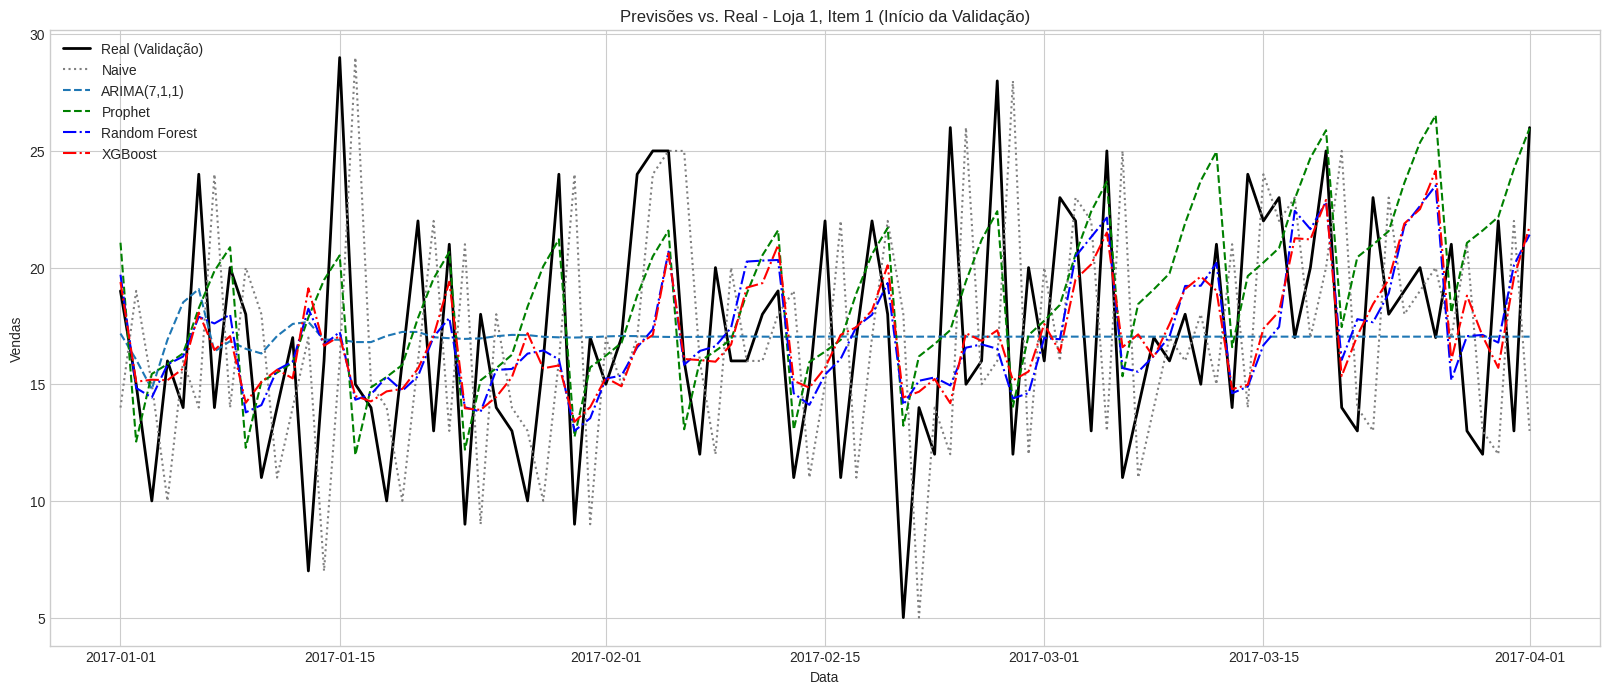

In [36]:
# Cell 33: Visualização das Previsões vs. Real (Início da Validação) (CORRIGIDA)
# Get date range based on the 'date' column from df_val
plot_start_date = df_val['date'].min()
plot_end_date = plot_start_date + pd.Timedelta(days=90) # Agora a soma funciona

plt.figure(figsize=(20, 8))

# --- Plotting ---
# Set 'date' as index temporarily for easy slicing with .loc and dates
df_val_indexed = df_val.set_index('date')

# Plot Real data using the DatetimeIndex
plt.plot(df_val_indexed.loc[plot_start_date:plot_end_date].index,
         df_val_indexed.loc[plot_start_date:plot_end_date, 'sales'], # Access 'sales' column
         label='Real (Validação)', color='black', linewidth=2)

# Plot Previsões (assuming prediction series now have DatetimeIndex after corrections)

# Naive - Reconstruir com DatetimeIndex para plotar
y_pred_naive_dt_idx = df_val_indexed['sales'].shift(1) # Naive forecast com date index
if not df_train.empty: # Certifique-se que df_train não está vazio
    last_train_date_sales = df_train.set_index('date')['sales'].iloc[-1]
    y_pred_naive_dt_idx.iloc[0] = last_train_date_sales # Preenche o primeiro NaN
y_pred_naive_dt_idx = y_pred_naive_dt_idx.fillna(method='ffill') # Preenche outros possíveis NaNs iniciais

if 'y_pred_naive_dt_idx' in locals() and not y_pred_naive_dt_idx.loc[plot_start_date:plot_end_date].isnull().all():
     plt.plot(y_pred_naive_dt_idx.loc[plot_start_date:plot_end_date].index,
              y_pred_naive_dt_idx.loc[plot_start_date:plot_end_date],
              label='Naive', linestyle=':', color='gray')


# Plot ARIMA (já deve ter DatetimeIndex)
if 'arima_preds' in locals() and not arima_preds.isnull().all():
    # Check if date range exists in index before slicing
    plot_arima = arima_preds.loc[plot_start_date:plot_end_date]
    if not plot_arima.empty:
         plt.plot(plot_arima.index, plot_arima, label=f'ARIMA({p},{d},{q})', linestyle='--')

# Plot Prophet (deve ter DatetimeIndex após correção)
if 'prophet_preds' in locals() and not prophet_preds.isnull().all():
    plot_prophet = prophet_preds.loc[plot_start_date:plot_end_date]
    if not plot_prophet.empty:
         plt.plot(plot_prophet.index, plot_prophet, label='Prophet', linestyle='--', color='green')

# Plot Random Forest (deve ter DatetimeIndex após correção)
if 'rf_preds' in locals() and not rf_preds.isnull().all():
    plot_rf = rf_preds.loc[plot_start_date:plot_end_date]
    if not plot_rf.empty:
         plt.plot(plot_rf.index, plot_rf, label='Random Forest', linestyle='-.', color='blue')

# Plot XGBoost (deve ter DatetimeIndex após correção)
if 'xgb_preds' in locals() and not xgb_preds.isnull().all():
    plot_xgb = xgb_preds.loc[plot_start_date:plot_end_date]
    if not plot_xgb.empty:
         plt.plot(plot_xgb.index, plot_xgb, label='XGBoost', linestyle='-.', color='red')


plt.title(f'Previsões vs. Real - Loja {store_id}, Item {item_id} (Início da Validação)')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend(loc='best')
plt.show()

Índice dos Resíduos: DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05'],
              dtype='datetime64[ns]', name='date', freq=None)
Tipo do Índice dos Resíduos: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


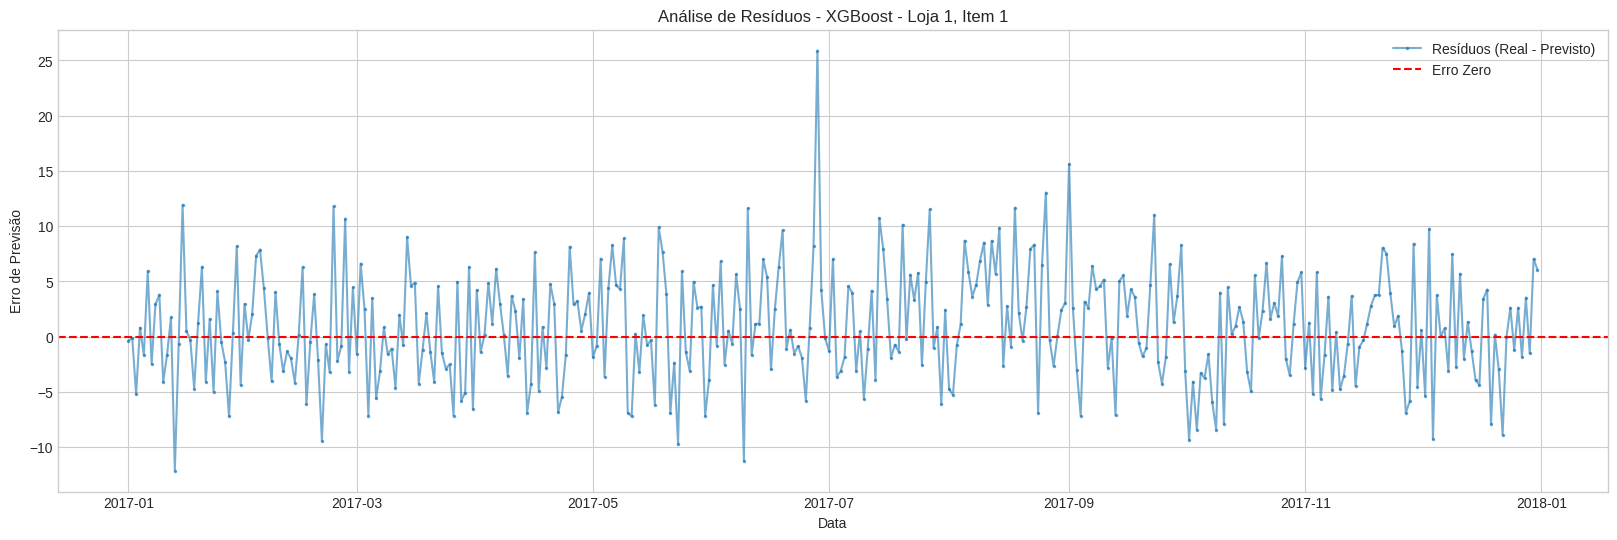

In [37]:
# Cell 34: Análise de Resíduos (Exemplo com XGBoost) (CORRIGIDO)

# Certifique-se de que y_val tenha o mesmo DatetimeIndex que xgb_preds antes de subtrair
# Crie uma versão de y_val com o índice de data correto
y_val_dt_indexed = pd.Series(y_val.values, index=df_val.set_index('date').index)

# Verifique se xgb_preds tem o índice esperado (DatetimeIndex)
if not isinstance(xgb_preds.index, pd.DatetimeIndex):
     print("Alerta: xgb_preds não tem um DatetimeIndex como esperado!")
     # Tentar reindexar xgb_preds também, se necessário (mas isso não deveria ser preciso após a Cell 30 corrigida)
     # xgb_preds = xgb_preds.reindex(y_val_dt_indexed.index) # Cuidado com essa linha

# Agora calcule os resíduos. Ambas as séries devem ter o mesmo DatetimeIndex.
residuals_xgb = y_val_dt_indexed - xgb_preds

# Verifique o índice resultante
print("Índice dos Resíduos:", residuals_xgb.index[:5]) # Mostrar as primeiras datas do índice
print("Tipo do Índice dos Resíduos:", type(residuals_xgb.index))

# Plotar os resíduos contra o tempo (o índice agora DEVE ser DatetimeIndex)
plt.figure(figsize=(20, 6))
# Passar explicitamente .values para o eixo y pode ajudar em alguns casos
plt.plot(residuals_xgb.index, residuals_xgb.values, label='Resíduos (Real - Previsto)', linestyle='-', marker='.', markersize=3, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label='Erro Zero')
plt.title(f'Análise de Resíduos - XGBoost - Loja {store_id}, Item {item_id}')
plt.xlabel('Data')
plt.ylabel('Erro de Previsão')
plt.legend()
plt.show()

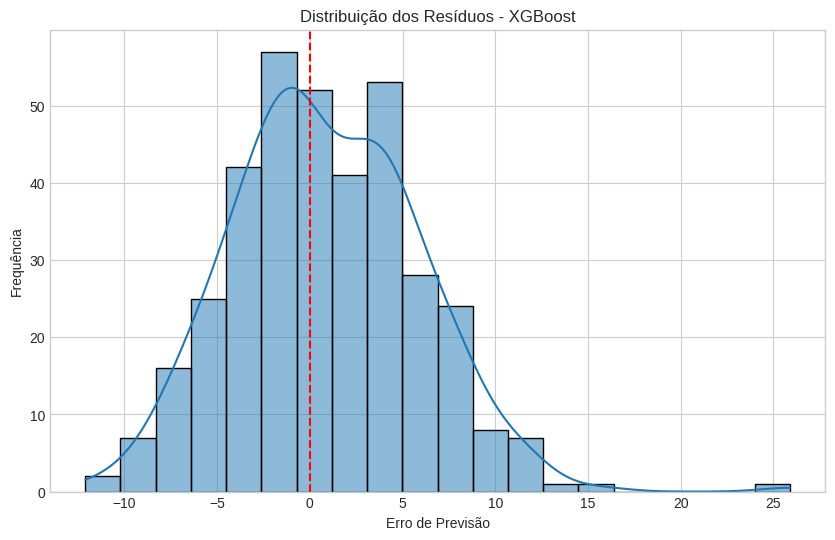


Estatísticas dos Resíduos (XGBoost):
Média: 0.881
Desvio Padrão: 5.028


In [38]:
# Cell 35: Distribuição dos Resíduos (XGBoost)
plt.figure(figsize=(10, 6))
sns.histplot(residuals_xgb.dropna(), kde=True) # dropna para histplot
plt.title('Distribuição dos Resíduos - XGBoost')
plt.xlabel('Erro de Previsão')
plt.ylabel('Frequência')
plt.axvline(0, color='red', linestyle='--')
plt.show()

print(f"\nEstatísticas dos Resíduos (XGBoost):")
print(f"Média: {residuals_xgb.mean():.3f}")
print(f"Desvio Padrão: {residuals_xgb.std():.3f}")


--- Importância das Features (XGBoost) ---
               feature  importance
7           is_weekend       0.183
15  sales_roll_mean_14       0.158
13   sales_roll_mean_7       0.116
3            dayofweek       0.116
17  sales_roll_mean_28       0.055
5           weekofyear       0.041
18   sales_roll_std_28       0.027
19  sales_roll_mean_90       0.025
9          sales_lag_7       0.025
10        sales_lag_14       0.024
20   sales_roll_std_90       0.023
16   sales_roll_std_14       0.023
4            dayofyear       0.023
11        sales_lag_28       0.023
12       sales_lag_365       0.022


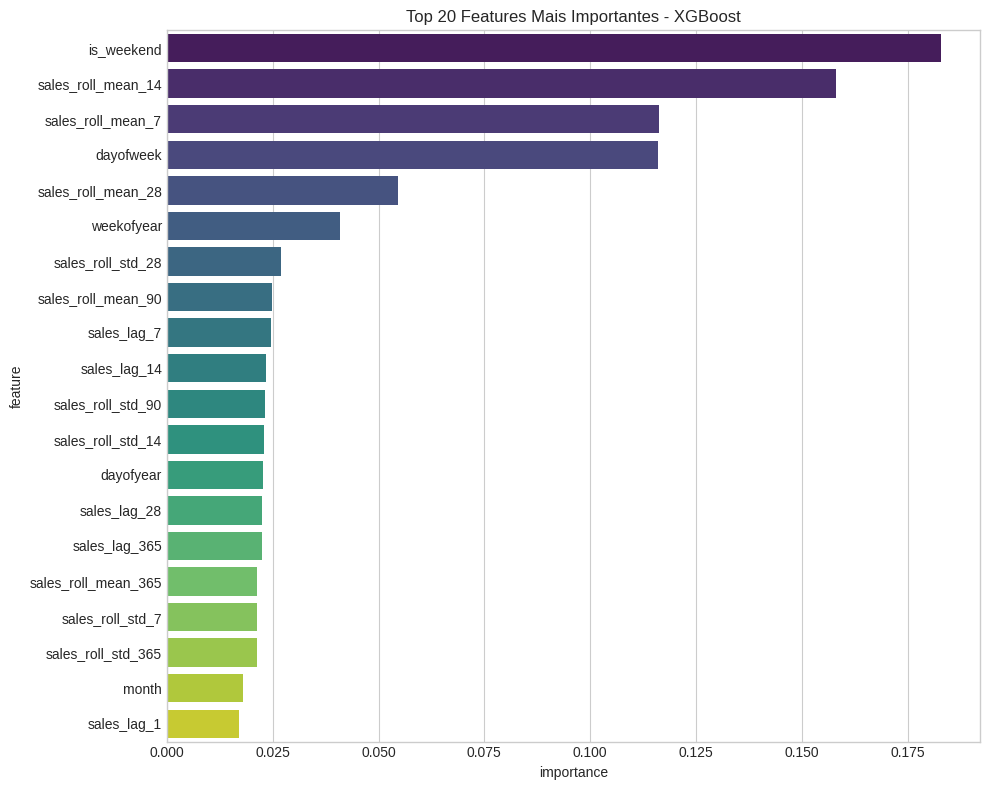

In [39]:
# Cell 36: Importância das Features (XGBoost)
if hasattr(model_xgb, 'feature_importances_') and len(features) == len(model_xgb.feature_importances_):
    feature_importance_xgb = pd.DataFrame({
        'feature': features,
        'importance': model_xgb.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\n--- Importância das Features (XGBoost) ---")
    print(feature_importance_xgb.head(15))

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_xgb.head(20), palette='viridis')
    plt.title('Top 20 Features Mais Importantes - XGBoost')
    plt.tight_layout()
    plt.show()
else:
    print("Não foi possível obter ou alinhar importância das features do XGBoost.")


--- Importância das Features (Random Forest) ---
               feature  importance
13   sales_roll_mean_7       0.186
15  sales_roll_mean_14       0.184
3            dayofweek       0.153
17  sales_roll_mean_28       0.085
7           is_weekend       0.036
9          sales_lag_7       0.033
14    sales_roll_std_7       0.030
12       sales_lag_365       0.028
11        sales_lag_28       0.027
10        sales_lag_14       0.026
4            dayofyear       0.025
2                  day       0.025
16   sales_roll_std_14       0.025
18   sales_roll_std_28       0.023
20   sales_roll_std_90       0.022


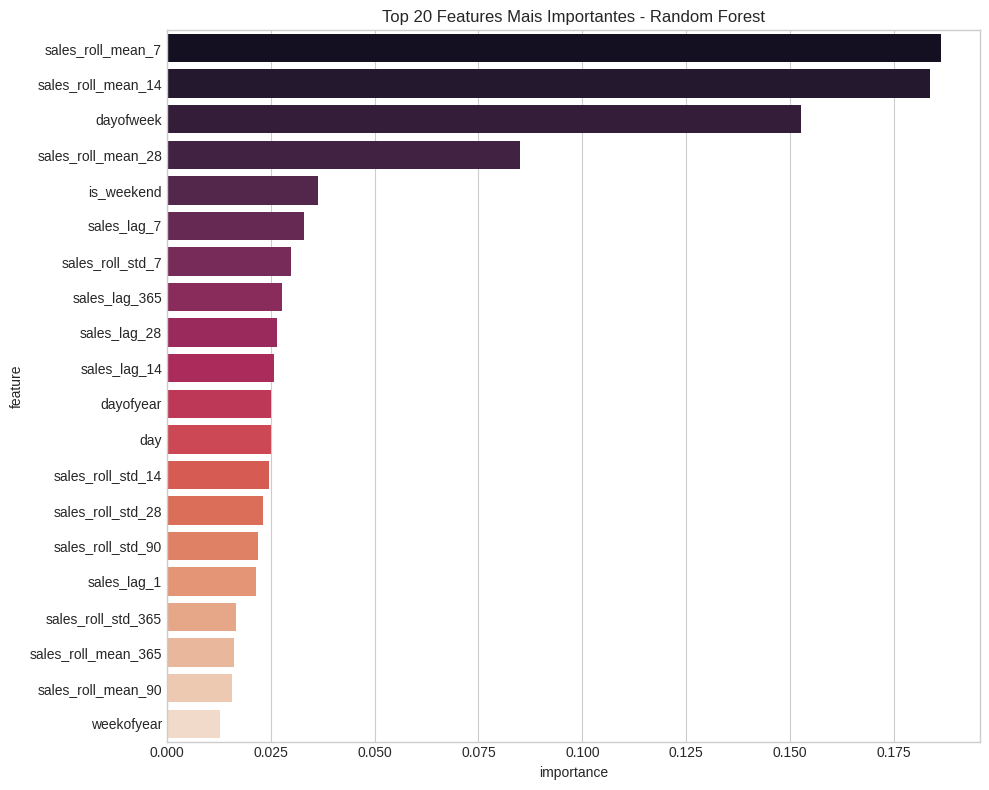

In [40]:
# Cell 37: Importância das Features (Random Forest)
if hasattr(model_rf, 'feature_importances_') and len(features) == len(model_rf.feature_importances_):
    feature_importance_rf = pd.DataFrame({
        'feature': features,
        'importance': model_rf.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\n--- Importância das Features (Random Forest) ---")
    print(feature_importance_rf.head(15))

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_rf.head(20), palette='rocket')
    plt.title('Top 20 Features Mais Importantes - Random Forest')
    plt.tight_layout()
    plt.show()
else:
    print("Não foi possível obter ou alinhar importância das features do Random Forest.")

---
## Fase 5: Conclusão e Próximos Passos
---

### 5.1 Resumo dos Resultados

Neste projeto, desenvolvemos e avaliamos múltiplos modelos (Naive, ARIMA, Prophet, Random Forest, XGBoost) para prever as vendas diárias do SKU correspondente à Loja 1, Item 1, utilizando 5 anos de dados históricos. A avaliação quantitativa no conjunto de validação (ano 2017) foi realizada com sucesso.

**Principais Descobertas e Observações:**

1.  **Comparativo de Performance (Métricas):**
    *   Os modelos de Machine Learning (**XGBoost** e **Random Forest**) alcançaram o menor **MAPE** (Erro Percentual Absoluto Médio), ambos em torno de **20.4%**, representando a melhoria mais significativa em relação ao baseline **Naive** (MAPE ≈ 33%).
    *   O modelo **Prophet** apresentou o menor **RMSE** (Raiz do Erro Quadrático Médio) com **4.918**, ligeiramente melhor que Random Forest (4.997) e XGBoost (5.098). Isso sugere que, embora o Prophet possa não ter capturado os picos e vales tão bem visualmente, ele pode ter evitado erros muito grandes com mais frequência que os modelos baseados em árvore.
    *   Todos os modelos complexos (Prophet, RF, XGBoost) superaram substancialmente o baseline **Naive** e o modelo **ARIMA(7,1,1)** em ambas as métricas.
    *   O modelo **ARIMA(7,1,1)**, apesar de identificar corretamente a sazonalidade semanal no treino (coeficiente `ar.L7` significativo), teve o pior desempenho entre os modelos complexos na validação (RMSE 8.635, MAPE 29.5%).

2.  **Análise Visual (Gráfico Previsões vs. Real):**
    *   O gráfico confirma que **XGBoost** e **Random Forest** seguem mais de perto as flutuações diárias/semanais dos dados reais, alinhando-se com seu desempenho superior em MAPE.
    *   **Prophet** e **ARIMA** geraram previsões mais suaves, perdendo parte da dinâmica de curto prazo, o que explica seu MAPE mais alto, apesar do bom RMSE do Prophet.

3.  **Análise de Resíduos (XGBoost):**
    *   Os resíduos do XGBoost estão bem distribuídos em torno de zero, sem padrões óbvios de tendência ou sazonalidade restante.
    *   A média dos resíduos foi ligeiramente positiva (0.881), indicando uma pequena tendência do XGBoost a *subestimar* as vendas, em média, no período de validação.
    *   Ainda existem alguns erros pontuais grandes, sugerindo que eventos específicos ou ruído aleatório não foram completamente capturados.

4.  **Importância das Features (XGBoost e Random Forest):**
    *   Ambos os modelos concordam que **features de janela móvel recentes** (`sales_roll_mean_7`, `sales_roll_mean_14`, `sales_roll_mean_28`) e **indicadores de padrão semanal** (`is_weekend`, `dayofweek`) são os preditores mais importantes para este SKU.
    *   Isso valida a engenharia de features realizada, mostrando que a história recente e a sazonalidade semanal são cruciais.

**Conclusão Geral:** Para o SKU (Loja 1, Item 1), os modelos **XGBoost** e **Random Forest** forneceram as previsões com o menor erro percentual médio (MAPE ≈ 20.4%), demonstrando uma capacidade superior de capturar a dinâmica de curto prazo das vendas. O **Prophet** também se mostrou competitivo, especialmente em termos de RMSE. Todos representam uma melhoria substancial sobre abordagens mais simples como Naive ou ARIMA univariado.

### 5.2 Limitações

*   **Foco em um SKU:** A análise e otimização foram realizadas apenas para a Loja 1, Item 1. O melhor modelo e seus parâmetros podem variar para outros SKUs com diferentes padrões de vendas.
*   **Ausência de Dados Externos:** Fatores como feriados específicos, dias de promoção, clima, ou eventos locais não foram incluídos no modelo, embora possam explicar alguns dos erros maiores observados nos resíduos.
*   **Otimização de Hiperparâmetros Limitada:** Os hiperparâmetros dos modelos foram definidos com base em valores comuns ou exemplos. Uma busca sistemática (HPO) poderia refinar os resultados e potencialmente desempatar a performance entre Prophet, RF e XGBoost.
*   **Interpretabilidade:** Modelos baseados em árvore (RF, XGBoost) são menos diretamente interpretáveis que ARIMA ou Prophet em termos de componentes de tendência e sazonalidade explícitos.

### 5.3 Próximos Passos e Melhorias

1.  **Hyperparameter Optimization (HPO):** Implementar `GridSearchCV` ou `RandomizedSearchCV` com `TimeSeriesSplit` para encontrar os melhores hiperparâmetros para XGBoost, Random Forest e potencialmente Prophet (ajustando `changepoint_prior_scale`, `seasonality_prior_scale`). Isso pode melhorar ainda mais as métricas.
2.  **Engenharia de Features Avançada:**
    *   Incorporar um calendário de feriados.
    *   Criar features indicando dias próximos a feriados ou eventos conhecidos.
    *   Testar diferentes janelas móveis ou agregações (mediana, min, max).
3.  **Escalar a Solução:** Adaptar o pipeline para treinar e avaliar modelos para múltiplos SKUs, permitindo uma análise mais ampla e a possível implementação de modelos globais.
4.  **Explorar Modelos Alternativos/Híbridos:** Testar LightGBM, CatBoost, ou modelos de Deep Learning (LSTM). Considerar fazer um *ensemble* (média ponderada) das previsões dos melhores modelos (ex: XGBoost e Prophet).
5.  **Investigar Grandes Erros:** Analisar as datas específicas onde os modelos tiveram os maiores erros para tentar identificar causas externas ou padrões não capturados.
6.  **Análise de Custo-Benefício:** Avaliar os modelos não apenas por métricas estatísticas, mas também pelo impacto potencial no negócio (custo de estoque vs. custo de ruptura) associado aos erros de previsão.

### 5.4 Impacto no Negócio (Logística e Supply Chain)

Este projeto demonstra com sucesso a aplicação de técnicas de Machine Learning para gerar previsões de demanda em nível de SKU significativamente mais precisas do que métodos simples ou modelos ARIMA básicos. A redução do MAPE de ~33% (Naive) para ~20% (XGBoost/RF) tem implicações diretas e valiosas:

*   **Otimização de Estoque:** Permite níveis de estoque mais enxutos e precisos, reduzindo custos e riscos associados ao excesso ou falta de produtos.
*   **Planejamento de Demanda:** Melhora a eficiência das compras, produção e reabastecimento.
*   **Eficiência Operacional:** Auxilia no planejamento de mão de obra, espaço e transporte nos centros de distribuição e lojas.
*   **Melhoria do Nível de Serviço:** Contribui para maior disponibilidade de produtos e satisfação do cliente.

A implementação e o refinamento contínuo de modelos de previsão robustos são, portanto, um investimento estratégico chave para otimizar operações de logística e supply chain.

---